In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [2]:
class NN(tf.Module):
    
    def __init__(self, layers, lb, ub, **kwargs):
        """A dense Neural Net that is specified by layers argument.
        
           layers: input, dense layers and outputs dimensions  
           lb    : An array of minimums of inputs (lower bounds)
           ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)        
        self.lb = lb
        self.ub = ub
        self.build()
        
    def build(self):         
        """Create the state of the layers (weights)"""
        weights = []
        biases = []        
        for l in range(0,self.num_layers-1):
            W = self.xavier_init(size=[self.layers[l], self.layers[l+1]])
            b = tf.Variable(tf.zeros([1,self.layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
        self.Ws = weights
        self.bs = biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.compat.v1.truncated_normal([in_dim, out_dim], 
                                                         stddev=xavier_stddev, 
                                                         dtype=tf.float32), 
                           dtype=tf.float32)
    
        
    @tf.function
    def __net__(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0*(inputs - self.lb)/(self.ub - self.lb) - 1.0
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs
    
    def __call__(self, inputs, grads=True):
        """Defines the computation from inputs to outputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           grads:  Default 'True'. Returns the first and second 
                   order gradients of the output with respect to 
                   the input when the grads argument is 'True'.
                   
        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
                When 'grads=True', the list of first and second order gradients 
                of the output with respect to the input. 
                
        The returns 'partial_1' and 'partial_2' are the first and second 
        order gradients, repsectivly. Each one is a list that its elements
        corresponds to on of the NN's last layer output. e.g. if the last layer
        has Dn outputs, each list has Dn tensors as an elements. The dimensionality
        of the tensors are the same as inputs: [None, D1]
        
        """
        X = tf.cast(inputs, tf.float32)
        outputs = self.__net__(X)
        if grads:                        
            partials_1 = [tf.gradients(outputs[:,i], X)[0] for i in range(outputs.shape[1])]
            partials_2 = [tf.gradients(partials_1[i], X)[0] for i in range(outputs.shape[1])]
            return outputs, partials_1, partials_2            
        else:            
            return outputs 
        
    def copy(self):
        return copy.deepcopy(self)
    
    
class Loss():
    def __init__(self, pinn, name, data_size = 0, init_loss_weight = 1.0):
        """Loss value that is calulated for the output of the pinn
        
        Args:
            pinn: NN object that will be trained.
            name: The name of the Loss
            data_size: The length of its internal dataset.
            init_loss_weight: Initial weigth of the loss in comparision to others.
            
            
            When the Loss class has some internal data (e.g. inputs),
            it must provid the length of its data_size, since that value
            will be used to create randomly shuffled indices on btach training
            time.
        
        
        """
        self.pinn = pinn
        self.data_size = data_size
        self.name = name      
        self.init_loss_weight = init_loss_weight
    
    
    def batch(self, indices):
        """Returns a batch that will be proccessed in loss method
        
        Args:
           indices: Randomly shuffled indices for the current batch.
           
           Each loss class is responsible for its data. However, the 
           batch indices are provided by TINN class. So, this method
           slices the data that it will use in loss calculation (loss method)
           Note that whatever returns fromthis method will be the batch argument
           of the loss method, which is casted as Tensor by tensorflow.
           
           Example:
             return (self.input_1[indices], self.input_2[indices])
           
        """
        pass
    
    #@tf.function
    def loss(self, batch):
        """A tensorflow function that calculates and returns the loss
        
        Args:
           batch: This is the value(s) that is returned from batch method.
                  Note that the values are converted to Tensors by Tensorflow
                  
           It must return the loss values
           
           Example:
              input_1, input_2 = batch
              ouput_1 = self.pinn(input_1)
              ouput_2 = self.pinn(input_2)
              L = tf.reduce_sum(tf.square(output_1 - output_1), name=self.name)
              return L
        
        """
        pass
    
    def loss_weight(self, iteration):
        """Return weigth of the loss in comparision to others
        
        Args: 
            iteration: the iteration index ( for hyper-parametrs that update
                       during the training)
        """
        return self.init_loss_weight
    
    def trainable_vars(self):
        """Retruns a list of Tensorflow variables for training
        
           If the loss class has some tarinable variables, it can
           return them as a list. These variables will be updated 
           by optimiser, if they are already part of the computation 
           graph.
        
        """
        return []
    
    def trainable_vars_str(self):  
        s = ""
        t_vars = self.trainable_vars()
        if len(t_vars) > 0:
            s +=  ", ".join([ f"{v.name}:{self.__get_val__(v):.8f}" for v in t_vars])
        return s
    
    def __get_val__(self, item):
        val = item.numpy()
        if type(val) is float:
            return val
        else:
            return val[0]
        
        
    
class Observations(Loss):
    def __init__(self, pinn, inputs_obs, outputs_obs, init_loss_weight = 1.0):        
        self.inputs_obs = inputs_obs
        self.outputs_obs = outputs_obs
        super().__init__(pinn, "Loss_observations", inputs_obs.shape[0], init_loss_weight)
        
    def batch(self, indices):
        return (tf.convert_to_tensor(self.inputs_obs[indices]), 
                tf.cast(tf.convert_to_tensor(self.outputs_obs[indices]), tf.float32))
    
    @tf.function
    def loss(self, batch):
        inputs, outputs = batch        
        obs_pred = self.pinn(inputs, grads = False)
        L = tf.reduce_sum(tf.square(obs_pred - outputs), name = self.name)
        return L
    
class Periodic_boundary(Loss):
    def __init__(self, pinn, inputs_LB_boundary, inputs_RT_boundary, init_loss_weight = 1.0):        
        self.inputs_LB_boundary = inputs_LB_boundary
        self.inputs_RT_boundary = inputs_RT_boundary
        super().__init__(pinn, "Loss_Periodic_Boundary", inputs_LB_boundary.shape[0], init_loss_weight)
    
    def batch(self, indices):
        return (tf.convert_to_tensor(self.inputs_LB_boundary[indices]), 
                tf.convert_to_tensor(self.inputs_RT_boundary[indices]))
    
    #@tf.function
    def loss(self, batch):
        inputs_LB, inputs_RT = batch
        boundary_LB_pred = self.pinn(inputs_LB, grads = False)
        boundary_RT_pred = self.pinn(inputs_RT, grads = False)
        L = tf.reduce_sum(tf.square(boundary_LB_pred - boundary_RT_pred), 
                          name = self.name)
        return L
    
class Truing_PDE(Loss):
    def __init__(self, pinn, inputs_pde, name="Loss_Turing_PDE", init_loss_weight = 1.0):        
        self.inputs_pde = inputs_pde
        super().__init__(pinn, name ,inputs_pde.shape[0], init_loss_weight)
        
    def batch(self, indices):
        return tf.convert_to_tensor(self.inputs_pde[indices])
       
    #@tf.function
    def loss(self, batch):
        inputs = batch
        pde_outputs, partials_1, partials_2 = self.pinn(inputs, grads = True)
        
        pde_res = self.pde(pde_outputs, partials_1, partials_2)
        L = tf.reduce_sum(tf.square(pde_res), name = self.name)
        return L
    
    def pde(self, outputs, partials_1, partials_2):
        pass
    
class ASDM(Truing_PDE):
    def __init__(self, 
                 pinn, 
                 inputs_pde, 
                 init_loss_weight = 1.0,
                 sigma_a = 1.0,
                 sigma_s = 1.0,
                 mu_a = 1.0,
                 rho_a = 1.0,
                 rho_s = 1.0,
                 kappa_a = 1.0
                ):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight= init_loss_weight)
        
        self.sigma_a = tf.Variable([sigma_a], dtype=tf.float32,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([sigma_s], dtype=tf.float32, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([mu_a], dtype=tf.float32, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([rho_a], dtype=tf.float32, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([rho_s], dtype=tf.float32, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([kappa_a], dtype=tf.float32,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def trainable_vars(self):
        return [self.sigma_a,
                self.sigma_s,                
                self.rho_a,
                self.rho_s,
                self.mu_a,
                self.kappa_a]
        
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float32)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a, axis=1), 
                          tf.expand_dims(f_s, axis=1)], axis = 1)
    
class ASDM_full(Truing_PDE):
    def __init__(self, pinn, inputs_pde, init_loss_weight = 1.0):
        super().__init__(pinn, inputs_pde, name="Loss_ASDM", init_loss_weight= init_loss_weight)
        self.D_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="D_a",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
        self.D_s = tf.Variable([1.00], dtype=tf.float32, 
                                   name="D_s",
                                   constraint= lambda z: tf.clip_by_value(z, 1e-8, 1e10))
        
        self.sigma_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="sigma_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                   name="sigma_s",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                name="mu_a",
                                constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                 name="rho_a",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                 name="rho_s",
                                 constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                   name="kappa_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    def trainable_vars(self):
        return [self.D_a,
                self.D_s,
                self.sigma_a,
                self.sigma_s,
                self.rho_a,
                self.rho_s,
                self.mu_a,
                self.kappa_a]
        
    def pde(self, outputs, partials_1, partials_2):
        a = outputs[:, 0]
        s = outputs[:, 1]
        
        a_x = partials_1[0][:, 0]
        a_y = partials_1[0][:, 1]
        a_t = partials_1[0][:, 2]
        
        a_xx = partials_2[0][:, 0]
        a_yy = partials_2[0][:, 1]
        
        
        s_x = partials_1[1][:, 0]
        s_y = partials_1[1][:, 1]
        s_t = partials_1[1][:, 2]
        
        s_xx = partials_2[1][:, 0]
        s_yy = partials_2[1][:, 1]
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        one_1 = tf.constant(1.0, dtype=tf.float32)
        f = a*a*s/(one_1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return tf.concat([tf.expand_dims(f_a, axis=1), 
                          tf.expand_dims(f_s, axis=1)], axis = 1)
class TINN():
    """Turing-Informed Neoral Net"""
    def __init__(self,
                 pinn: NN,
                 losses: Loss,
                 #optimizer = keras.optimizers.SGD(learning_rate=1e-6,
                 #                                 momentum=0.0,
                 #                                 nesterov=False)
                 optimizer = keras.optimizers.SGD(learning_rate=1e-6,
                                                  momentum=0.0,
                                                  nesterov=False),
                 fixed_pinn = False,
                 fixed_loss_params = False
                ):
        self.pinn = pinn
        self.losses = losses        
        #self.optimizer = keras.optimizers.Adam(epsilon=1.0)
        self.optimizer = optimizer
        self.fixed_pinn = fixed_pinn
        self.fixed_loss_params = fixed_loss_params
        self.__trainable_vars_tuple__ = None
        
    def trainable_vars(self):
        if self.__trainable_vars_tuple__ is None:
            self.__trainable_vars_tuple__ = ()
            if self.fixed_pinn == False:
                self.__trainable_vars_tuple__ += self.pinn.trainable_variables
            if self.fixed_loss_params == False:
                for l in self.losses:
                    self.__trainable_vars_tuple__ += tuple(l.trainable_vars())
            
        return self.__trainable_vars_tuple__
    
    def __indices__(self, batch_size: int, *ns):
        """Generator of indices for specified sizes"""
        n1 = ns[0]
        ns_remain = ns[1:] if len(ns) > 1 else []                
        # First indices        
        batch_steps = n1//batch_size
        batch_steps = batch_steps + (n1-1)//(batch_steps*batch_size)
        # remaining indices        
        indices_batch_size = [n_i//batch_steps for n_i in ns_remain]
        indices_batch_size = [size + (batch_size//size)*(batch_size%size)
                                for size in indices_batch_size]

        # indices
        indices = [np.array(list(range(n_i))) for n_i in ns]        
        for arr in indices:
            np.random.shuffle(arr)
            
        for batch in range(batch_steps):
            # Observation start-end
            n1_start = batch*batch_size
            n1_end = (batch+1)*batch_size
            n1_end = n1_end - (n1_end//n1)*(n1_end%n1)
            # remaining indices
            starts = [batch*size for size in indices_batch_size]
            ends = [(batch+1)*size for size in indices_batch_size]                                       
            # Correction for remining indices
            if batch == batch_steps-1:
                ends = [ns[i+1] if end != ns[i+1] else end  for i, end in enumerate(ns_remain)]
            # step's indices            
            yield [indices[0][n1_start:n1_end]] + \
                  [indices[i+1][star:end] for i, (star, end) in enumerate(zip(starts, ends))]                
      
                   
    def train(self, epochs, batch_size, print_iter=10, stop_threshold = 0):
        
        datasets_sizes = [ item.data_size for item in self.losses] 
        samples_total_loss = np.zeros(epochs)
        samples_losses = np.zeros((epochs,len(self.losses)))
        samples_params = np.zeros((epochs,
                                   len([item.numpy()[0]                                         
                                        for l in self.losses
                                        for item in l.trainable_vars()])))
        
        #batches_list_list = [
        #    [ l.batch(indices) 
        #     for l, indices in zip(self.losses, indices_list)]
        #     for indices_list in self.__indices__(batch_size, *datasets_sizes)
        #]
        
        
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0
            loss_vals = np.zeros(len(self.losses))

            for indices_list in self.__indices__(batch_size, *datasets_sizes):
                batches_list = [ l.batch(indices) for l, indices in zip(self.losses,indices_list)]                 
            #for batches_list in batches_list_list:
                batch_total_loss, batch_loss_vals = self.train_step(batches_list, 
                                                                    tf.convert_to_tensor(epoch))
                total_loss += batch_total_loss
                loss_vals += [l.numpy() for l in batch_loss_vals]

                
            if print_iter > 0 and (epoch == 0 or (epoch+1) % print_iter == 0):
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")
                start_time = time.time()
                
            samples_total_loss[epoch] = total_loss
            samples_losses[epoch, : ] = loss_vals
            samples_params[epoch, : ] = [item.numpy()[0]                                         
                                         for l in self.losses
                                         for item in l.trainable_vars()]
                        
            if total_loss <= stop_threshold :
                elapsed = time.time() - start_time
                print("###############################################")
                print("#           Early Stop                        #")
                print("###############################################")
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")                
                return (samples_total_loss[:epoch], samples_losses[:epoch,:], samples_params[:epoch,:]) 
            #gc.collect()
            #tf.keras.backend.clear_session()
            
        return (samples_total_loss, samples_losses, samples_params)
    
    
    
            
    @tf.function
    def train_step(self, batches_list, iteration):        
                   
        with tf.GradientTape(persistent=False, watch_accessed_variables=True) as tape:            
            losses = []
            batch_loss = None
            for l, batch in zip(self.losses, batches_list):
                L = l.loss(batch)*l.loss_weight(iteration)
                losses += [L]
                if batch_loss is None:
                    batch_loss = L
                else:
                    batch_loss = batch_loss + L 
                
            #batch_loss = tf.reduce_sum(losses, name="Total_batch_loss")                                         
        
        grads = tape.gradient(batch_loss,  self.trainable_vars())
        self.optimizer.apply_gradients(zip(grads, self.trainable_vars()))
        
        return batch_loss, losses
    
    
    def train_experimental(self, epochs, batch_size, print_iter=10, stop_threshold = 0):
        
        datasets_sizes = [ item.data_size for item in self.losses] 
        samples_total_loss = np.zeros(epochs)
        samples_losses = np.zeros((epochs,len(self.losses)))
        samples_params = np.zeros((epochs,
                                   len([item.numpy()[0]                                         
                                        for l in self.losses
                                        for item in l.trainable_vars()])))
        samples_grads = []#np.zeros((epochs,len(self.losses)))
        
        
        start_time = time.time()
        for epoch in range(epochs):
            total_loss = 0
            loss_vals = np.zeros(len(self.losses))
            grads_vals = None#np.zeros(len(self.losses))

            for indices_list in self.__indices__(batch_size, *datasets_sizes):
                batches_list = [ l.batch(indices) for l, indices in zip(self.losses,indices_list)]                 
                batch_total_loss, batch_loss_vals, batch_grads_vals = \
                                       self.train_step_experimental(batches_list, 
                                                                    tf.convert_to_tensor(epoch))
                total_loss += batch_total_loss
                
                loss_vals += [l.numpy() for l in batch_loss_vals]
                if grads_vals is None:
                    #grads_vals = np.array([np.sum(np.abs(g.numpy())) for g in batch_grads_vals
                    #                      if g is not None])
                    grads_vals = np.abs(np.array(batch_grads_vals))
                else:
                    #grads_vals += [np.sum(np.abs(g.numpy())) for g in batch_grads_vals
                    #               if g is not None]
                    grads_vals += np.abs(np.array(batch_grads_vals))
                

                
            if print_iter > 0 and (epoch == 0 or (epoch+1) % print_iter == 0):
                elapsed = time.time() - start_time                                                                
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")
                start_time = time.time()
                
            samples_total_loss[epoch] = total_loss
            samples_losses[epoch, : ] = loss_vals
            #samples_grads[epoch, : ]  = grads_vals
            samples_grads  += [[[np.sum(v.numpy()) for v in L] for L in grads_vals]]
            samples_params[epoch, : ] = [item.numpy()[0]                                         
                                         for l in self.losses
                                         for item in l.trainable_vars()]
            
                        
            if total_loss <= stop_threshold :
                elapsed = time.time() - start_time
                print("###############################################")
                print("#           Early Stop                        #")
                print("###############################################")
                print(f"Epoch: {epoch+1}, loss:{total_loss:.2f}\n" + \
                      f"\n".join([ f"{l.name}:{val:.8f} {l.trainable_vars_str()}\n" 
                                  for l, val in zip(self.losses, loss_vals)] ) +\
                      f"\nTime:{elapsed:.2f}\n")                
                return (samples_total_loss[:epoch], 
                        samples_losses[:epoch,:], 
                        samples_params[:epoch,:],
                        np.array(samples_grads)) 
            gc.collect()
            tf.keras.backend.clear_session()
            
        return (samples_total_loss, samples_losses, samples_params, np.array(samples_grads))
    
    @tf.function
    def train_step_experimental(self, batches_list, iteration):        
            
        with tf.GradientTape(persistent=True, watch_accessed_variables=True) as tape:            
            losses = []
            batch_loss = None
            for l, batch in zip(self.losses, batches_list):
                L = l.loss(batch)*l.loss_weight(iteration)
                losses += [L]
                if batch_loss is None:
                    batch_loss = L
                else:
                    batch_loss = batch_loss + L 
                
            #batch_loss = tf.reduce_sum(losses, name="Total_batch_loss")                    
        
        grads = tape.gradient(batch_loss,  self.trainable_vars())
        self.optimizer.apply_gradients(zip(grads, self.trainable_vars()))
        #
        grads_parts = [tape.gradient(L,  self.trainable_vars()) for L in losses] 
        grads_parts = [[0.0 if v is None else v for v in g_part] for g_part in grads_parts] 
        #grads_parts = [tape.gradients(L,  self.trainable_vars()) for l, L in zip(self.losses, losses)]        
        
        #print(grads_parts)
        return batch_loss, losses, grads_parts#[tf.reduce_sum(g) for g in grads_parts]


In [3]:
def lower_upper_bounds(inputs_of_inputs):
    """Find the lower and upper bounds of inputs
    
       inputs_of_inputs: a list of tensors that their axis one have the same number 
                         of columns
    """
           
    inputs_dim = np.asarray(inputs_of_inputs[0]).shape[1]
    lb = np.array([np.inf] * inputs_dim)
    ub = np.array([-np.inf] * inputs_dim)
    for i, inputs in enumerate(inputs_of_inputs):        
        assert inputs_dim == np.asarray(inputs).shape[1]
        lb = np.amin(np.c_[inputs.min(0), lb], 1)
        ub = np.amax(np.c_[inputs.max(0), ub], 1)
        
    return lb, ub


In [4]:
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_RT = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_RT = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_RT = np.tile(boundary_x_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_RT = np.tile(boundary_y_RT.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'obs_input': np.c_[XX[idx_data], YY[idx_data],TT[idx_data]],
           'obs_output': np.c_[AA[idx_data], SS[idx_data]],
           'pde':   np.c_[XX[idx_pde], YY[idx_pde], TT[idx_pde]]}
    
    if signal_to_noise > 0:        
        ret['obs_output'][0] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['obs_output'][1] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'boundary_LB': np.c_[boundary_XX_LB[idx_boundary], 
                                       boundary_YY_LB[idx_boundary],
                                       boundary_TT[idx_boundary]],
                  'boundary_RT': np.c_[boundary_XX_RT[idx_boundary],
                                       boundary_YY_RT[idx_boundary],
                                       boundary_TT[idx_boundary]]
                 }
              }
    return ret



In [5]:
model_params_1 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(**model_params_1)
lb, ub = lower_upper_bounds([np.c_[XX, YY, TT]])

In [7]:
pinn = NN(layers, lb, ub)
loss_stack_1 = [Observations(pinn,
                       inputs_obs = dataset['obs_input'],
                       outputs_obs = dataset['obs_output']),
               ASDM(pinn,
                   inputs_pde = dataset['pde'],
                   init_loss_weight = 1.0)
               ]

In [8]:
model_1 = TINN(pinn, loss_stack_1, optimizer=keras.optimizers.Adam())
#model_1.optimizer.learning_rate=1e-4

In [9]:
arr_total_loss_1, arr_losses_1, samples_params_1, samples_grads_1 = \
         model_1.train_experimental(2000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0)

Epoch: 1, loss:41517.14
Loss_observations:17153.32464600 
Loss_ASDM:24363.81225586 sigma_a:0:0.98475736, sigma_s:0:0.98408300, rho_a:0:0.98644561, rho_s:0:1.00963092, mu_a:0:1.01198161, kappa_a:0:0.99721074
Time:7.84

Epoch: 100, loss:2202.17
Loss_observations:2195.05799866 
Loss_ASDM:7.11041608 sigma_a:0:0.81388611, sigma_s:0:0.84188122, rho_a:0:0.70493203, rho_s:0:1.28560901, mu_a:0:1.26767015, kappa_a:0:0.95123345
Time:153.16

Epoch: 200, loss:2204.18
Loss_observations:2196.31666565 
Loss_ASDM:7.86535004 sigma_a:0:0.80905110, sigma_s:0:0.83470786, rho_a:0:0.70416218, rho_s:0:1.28088462, mu_a:0:1.26210284, kappa_a:0:0.95938027
Time:147.12

Epoch: 300, loss:2198.85
Loss_observations:2192.38587952 
Loss_ASDM:6.46056885 sigma_a:0:0.79964560, sigma_s:0:0.82119274, rho_a:0:0.70497650, rho_s:0:1.27008581, mu_a:0:1.24900055, kappa_a:0:0.97483635
Time:147.63

Epoch: 400, loss:2197.95
Loss_observations:2191.24830627 
Loss_ASDM:6.70510541 sigma_a:0:0.78124666, sigma_s:0:0.80336344, rho_a:0:0.7

In [42]:
arr_total_loss_2, arr_losses_2, samples_params_2, samples_grads_2 = \
         model_1.train_experimental(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0)

Epoch: 1, loss:845.74
Loss_observations:731.75966644 
Loss_ASDM:113.98007107 sigma_a:0:0.00000000, sigma_s:0:0.03878871, rho_a:0:0.17713971, rho_s:0:0.02737394, mu_a:0:0.23600787, kappa_a:0:0.00000000
Time:1.46

Epoch: 100, loss:529.93
Loss_observations:402.98934937 
Loss_ASDM:126.93781853 sigma_a:0:0.00000000, sigma_s:0:0.05007484, rho_a:0:0.49637341, rho_s:0:0.04059633, mu_a:0:0.59307694, kappa_a:0:0.09472433
Time:162.32

Epoch: 200, loss:398.93
Loss_observations:282.70800018 
Loss_ASDM:116.21867371 sigma_a:0:0.00000000, sigma_s:0:0.05281722, rho_a:0:0.69296533, rho_s:0:0.04532848, mu_a:0:0.79287213, kappa_a:0:0.13266535
Time:166.27

Epoch: 300, loss:343.64
Loss_observations:236.06772709 
Loss_ASDM:107.57598209 sigma_a:0:0.00000000, sigma_s:0:0.05446476, rho_a:0:0.83055478, rho_s:0:0.04705958, mu_a:0:0.92828202, kappa_a:0:0.15355632
Time:166.11

Epoch: 400, loss:295.24
Loss_observations:193.88397217 
Loss_ASDM:101.35300350 sigma_a:0:0.00000000, sigma_s:0:0.05530022, rho_a:0:0.9284475

In [52]:
arr_total_loss_1 = np.r_[arr_total_loss_1,arr_total_loss_2]
samples_grads_1 = np.concatenate([samples_grads_1, samples_grads_2],axis=0)

In [54]:
arr_total_loss_2, arr_losses_2, samples_params_2, samples_grads_2 = \
         model_1.train_experimental(1000,
                       batch_size=dataset['obs_input'].shape[0]//16, 
                       print_iter=100,
                       stop_threshold = 1.0)

Epoch: 1, loss:191.80
Loss_observations:110.41581774 
Loss_ASDM:81.38340521 sigma_a:0:0.07366595, sigma_s:0:0.05523366, rho_a:0:1.25079262, rho_s:0:0.04860323, mu_a:0:1.44611919, kappa_a:0:0.17133674
Time:1.54

Epoch: 100, loss:179.19
Loss_observations:101.31928444 
Loss_ASDM:77.87480497 sigma_a:0:0.08403536, sigma_s:0:0.05496078, rho_a:0:1.29037356, rho_s:0:0.04924560, mu_a:0:1.50090611, kappa_a:0:0.17088081
Time:173.54

Epoch: 200, loss:170.82
Loss_observations:94.60958099 
Loss_ASDM:76.20592833 sigma_a:0:0.09454066, sigma_s:0:0.05470585, rho_a:0:1.32828999, rho_s:0:0.04909813, mu_a:0:1.55184233, kappa_a:0:0.17118065
Time:171.76

Epoch: 300, loss:159.93
Loss_observations:86.69159746 
Loss_ASDM:73.24020147 sigma_a:0:0.10366848, sigma_s:0:0.05559453, rho_a:0:1.36452627, rho_s:0:0.04880692, mu_a:0:1.60065627, kappa_a:0:0.17176339
Time:174.76

Epoch: 400, loss:161.13
Loss_observations:90.26684427 
Loss_ASDM:70.86787271 sigma_a:0:0.11209743, sigma_s:0:0.05502478, rho_a:0:1.39839470, rho_s

In [ ]:
arr_total_loss_1 = np.r_[arr_total_loss_1,arr_total_loss_2]
samples_grads_1 = np.concatenate([samples_grads_1, samples_grads_2],axis=0)

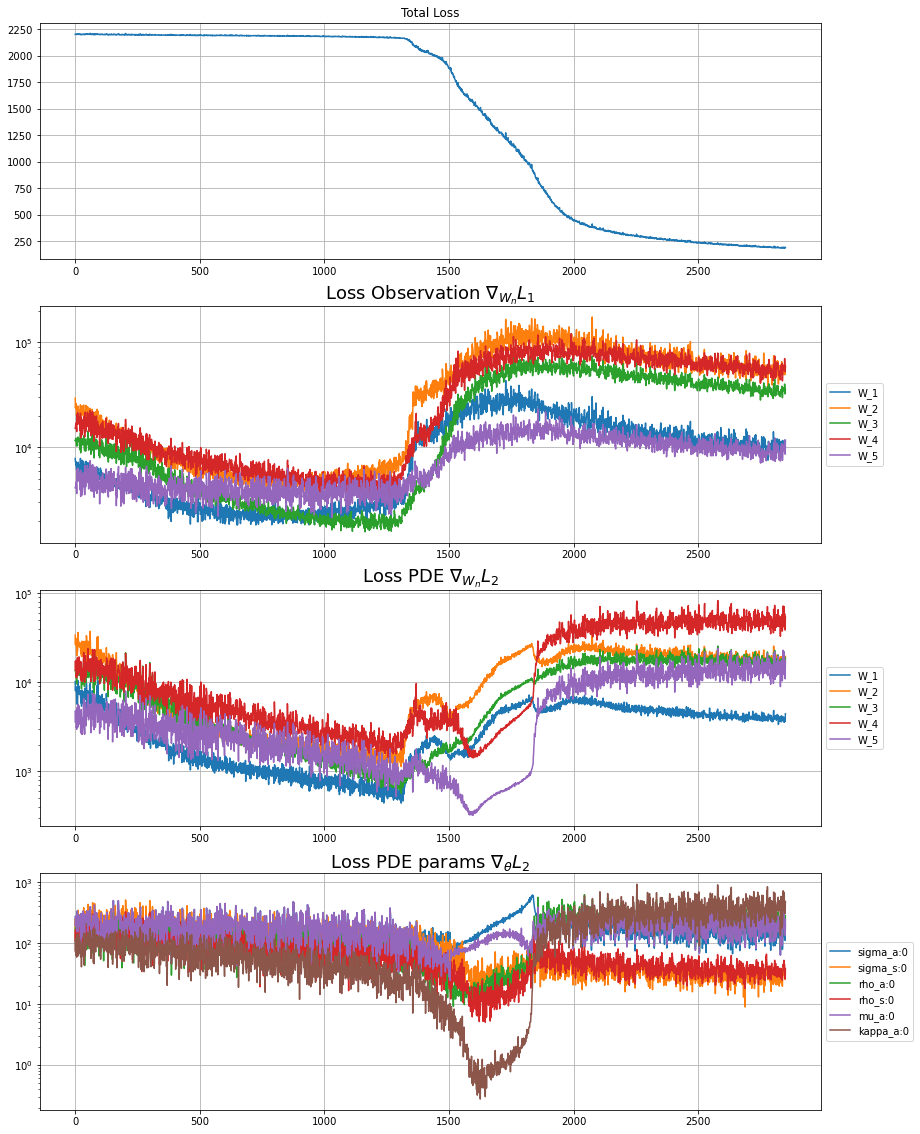

In [53]:
start = 150
W_n = len(layers)-1
param_names = [v.name for v in loss_stack_1[1].trainable_vars()]
params_len = len(param_names)

_ = plt.figure(figsize=(14,20))
plt.subplot(4,1,1)
plt.title("Total Loss")
plt.plot(arr_total_loss_1[start:])
plt.grid()

plt.subplot(4,1,2)
plt.title(r"Loss Observation $\nabla_{W_n} L_1$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,0,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,3)
plt.title(r"Loss PDE $\nabla_{W_n} L_2$", fontsize=18)
for i in range(W_n):
    plt.plot(samples_grads_1[start:,1,i], label=f"W_{i+1}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.subplot(4,1,4)
plt.title(r"Loss PDE params $\nabla_{\theta} L_2$", fontsize=18)
for j in range(params_len):
    plt.plot(samples_grads_1[start:,1,j+2*W_n], label=f"{param_names[j]}")
    
plt.yscale('log')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()